### Using Networkx to general graph

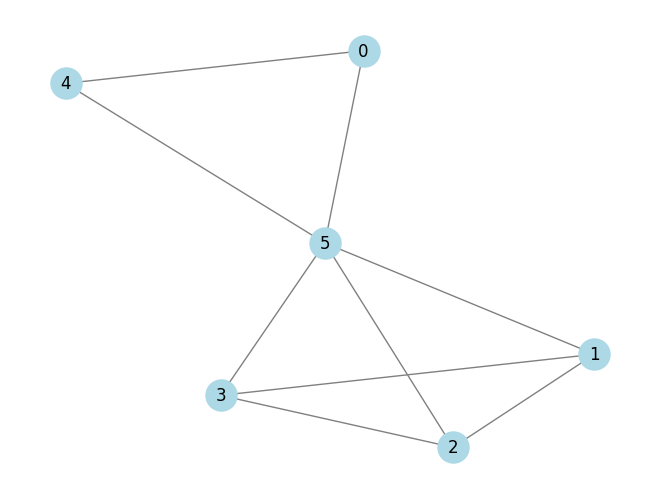

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Args
k = 4  # Degree of each node
n = 6  # Number of nodes
p = 0.5

graph_type = 'Random' # or 'Random'

# Generate k-regular graph
if graph_type == 'Regular':
    G = nx.random_regular_graph(k, n)
elif graph_type == 'Random':
    G = nx.erdos_renyi_graph(n, p)
    k = G.number_of_edges()

# Draw the graph
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500)
plt.show()

In [2]:
binary_vectors = [[False] * G.number_of_nodes() for i in range(G.number_of_edges())]

# Fill the binary matrix
for i, (u, v) in enumerate(G.edges):
    binary_vectors[i][u] = True  # Mark the first node of the edge
    binary_vectors[i][v] = True   # Mark the second node of the edge

In [3]:
import numpy as np

def hamming_distance(vec1, vec2):
    """
    Computes the Hamming distance between two binary vectors.
    
    :param vec1: First binary vector (list of 0/1 or True/False)
    :param vec2: Second binary vector (list of 0/1 or True/False)
    :return: Integer Hamming distance
    """
    return sum(a != b for a, b in zip(vec1, vec2))

def select_best_vector(reference_list, candidate_list):
    """
    Selects the vector from candidate_list that has the minimum total Hamming weight 
    with respect to all vectors in reference_list.
    
    :param reference_list: List of binary vectors (comparison base)
    :param candidate_list: List of binary vectors (selection pool)
    :return: The best binary vector from candidate_list
    """
    best_vector = None
    min_hamming_sum = float('inf')

    for candidate in candidate_list:
        total_hamming = sum(hamming_distance(candidate, ref) for ref in reference_list)
        
        if total_hamming < min_hamming_sum:
            min_hamming_sum = total_hamming
            best_vector = candidate

    return best_vector

ordered_F = []
candidate_F = [f for f in binary_vectors]
while candidate_F:
    # Select the best vector
    best_vector = select_best_vector(ordered_F, candidate_F)
    ordered_F.append(best_vector)
    candidate_F.remove(best_vector)

In [4]:
from QAOA_benchmark import boolean_func_to_normal_qaoa_circuit
import time
start_time = time.time()
org_qc, theta_2 = boolean_func_to_normal_qaoa_circuit(ordered_F,1)

parameter_values = [np.pi/5, np.pi/4]
parameter_dict = {param: value for param, value in zip(theta_2, parameter_values)}

# Bind the parameters
bound_org_qc = org_qc.assign_parameters(parameter_dict)

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=3)
candidate_circuit = pm.run(bound_org_qc)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

0.012730121612548828


In [5]:
from qiskit import QuantumCircuit, qpy
with open("MaxCut_"+graph_type+"/logical/"+graph_type+ str(candidate_circuit.num_qubits) +"_"+ str(k) +"_logical_circuit.qpy", "wb") as qpy_file_write:
    qpy.dump(candidate_circuit, qpy_file_write)